<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/7_TopicosAvanzados/3_VariationalModels/4_Var_autoencoders_and_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative models

In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Graficar imágenes:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA como un autoencoder lineal

In [3]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Definir autoencoder:

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 2s 15ms/step - loss: 0.3710
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3643
Epoch 3/20
2/2 [==============================] - 0s 8ms/step - loss: 0.3577
Epoch 4/20
2/2 [==============================] - 0s 8ms/step - loss: 0.3516
Epoch 5/20
2/2 [==============================] - 0s 8ms/step - loss: 0.3451
Epoch 6/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3391
Epoch 7/20
2/2 [==============================] - 0s 8ms/step - loss: 0.3334
Epoch 8/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3278
Epoch 9/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3224
Epoch 10/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3172
Epoch 11/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3121
Epoch 12/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3072
Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0

In [6]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 4ms/step


Saving figure linear_autoencoder_pca_plot


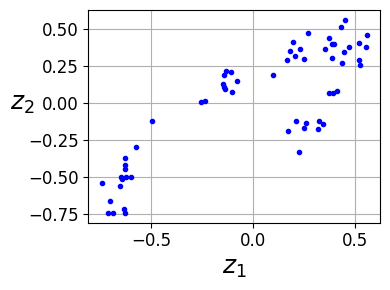

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked (Deep) Autoencoders

Utilizando MNIST:

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


Stacked Autoencoder con 3 hidden layers y 1 output layer.

In [9]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",# cada pixel como probailidad de membresia, por eso se usa cross entropy, converge mas rapido
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 21s 7ms/step - loss: 0.6557 - rounded_accuracy: 0.6116 - val_loss: 0.5962 - val_rounded_accuracy: 0.6925
Epoch 2/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5395 - rounded_accuracy: 0.7247 - val_loss: 0.5087 - val_rounded_accuracy: 0.7410
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4976 - rounded_accuracy: 0.7471 - val_loss: 0.4937 - val_rounded_accuracy: 0.7498
Epoch 4/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4851 - rounded_accuracy: 0.7591 - val_loss: 0.4808 - val_rounded_accuracy: 0.7655
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4692 - rounded_accuracy: 0.7773 - val_loss: 0.4614 - val_rounded_accuracy: 0.7848
Epoch 6/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4470 - rounded_accuracy: 0.7955 - val_loss: 0.4376 - val_rounded_accuracy: 0.8016
Epoch 7/20
1719/1719 [=================

Graficar reconstrucciones:

In [11]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 65ms/step
Saving figure reconstruction_plot


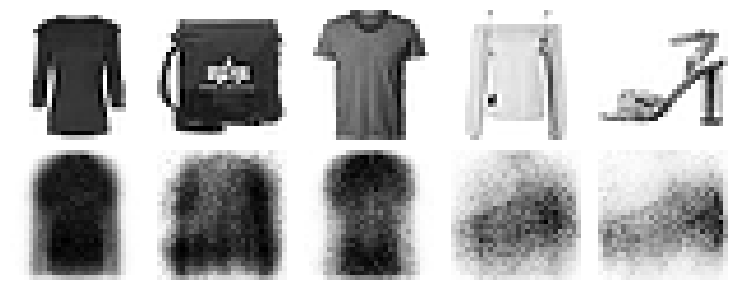

In [12]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

# Visualizando Fashion MNIST con tsne desde espacio latente del encoder

In [13]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min()) #normalizar rango dinamico

157/157 [==============================] - 0s 1ms/step


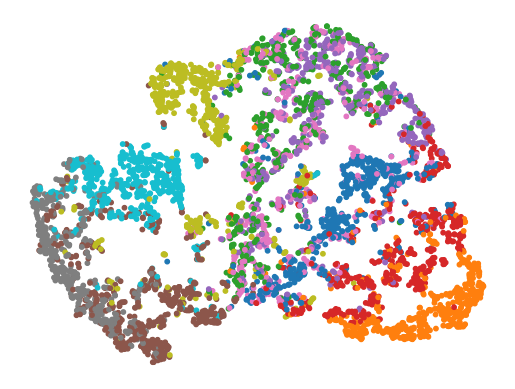

In [14]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Saving figure fashion_mnist_visualization_plot


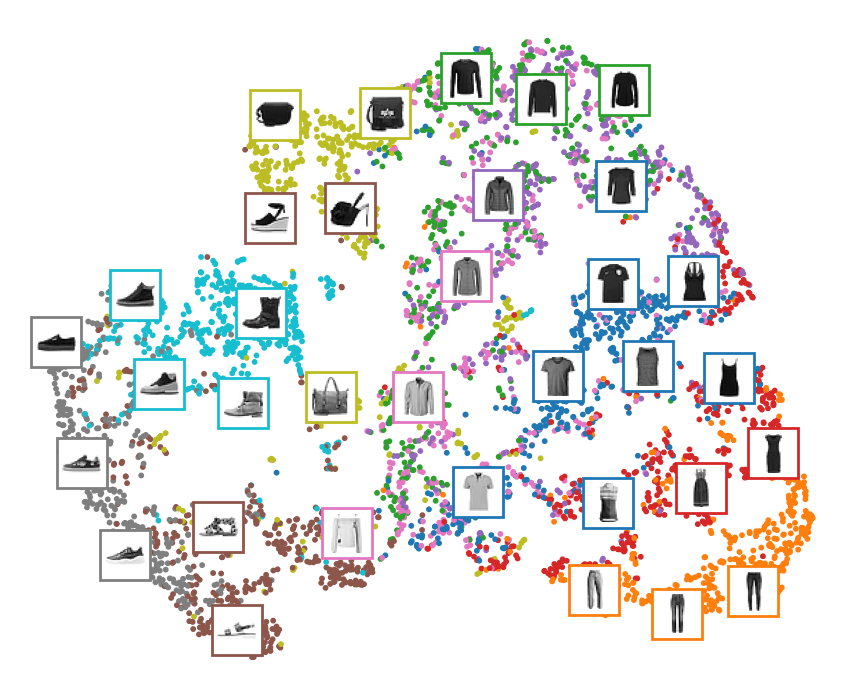

In [15]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.01: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Tying weights (relacionadar pesos  en encoder y decoder)

Se fijan los pesos del decoder como la transpuesta de los pesos del encoder (relacón directa con pca como reconstructor).

In [16]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6645 - rounded_accuracy: 0.6015 - val_loss: 0.6193 - val_rounded_accuracy: 0.6754
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5701 - rounded_accuracy: 0.7138 - val_loss: 0.5381 - val_rounded_accuracy: 0.7304
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5212 - rounded_accuracy: 0.7438 - val_loss: 0.5079 - val_rounded_accuracy: 0.7538
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4918 - rounded_accuracy: 0.7671 - val_loss: 0.4787 - val_rounded_accuracy: 0.7744
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4634 - rounded_accuracy: 0.7828 - val_loss: 0.4528 - val_rounded_accuracy: 0.7862
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4398 - rounded_accuracy: 0.7921 - val_loss: 0.4319 - val_rounded_accuracy: 0.7950
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 65ms/step


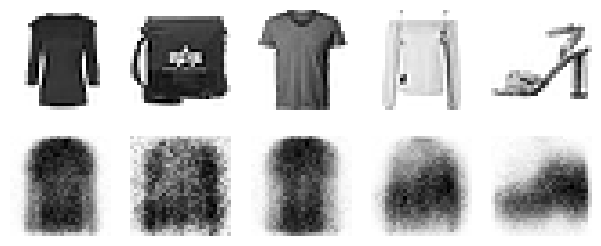

In [18]:
show_reconstructions(tied_ae)
plt.show()

## Training one Autoencoder at a Time

In [19]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6766 - rounded_accuracy: 0.5720 - val_loss: 0.6411 - val_rounded_accuracy: 0.6505
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5935 - rounded_accuracy: 0.6980 - val_loss: 0.5529 - val_rounded_accuracy: 0.7248
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5306 - rounded_accuracy: 0.7372 - val_loss: 0.5189 - val_rounded_accuracy: 0.7424
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5101 - rounded_accuracy: 0.7490 - val_loss: 0.5069 - val_rounded_accuracy: 0.7517
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5000 - rounded_accuracy: 0.7588 - val_loss: 0.4980 - val_rounded_accuracy: 0.7615
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4909 - rounded_accuracy: 0.7689 - val_loss: 0.4889 - val_rounded_accuracy: 0.7720
Epoch 7/10
1719/1719 [=================

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2454 - val_loss: 0.0844
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0700 - val_loss: 0.0625
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0576 - val_loss: 0.0549
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0518 - val_loss: 0.0501
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0476 - val_loss: 0.0464
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0444 - val_loss: 0.0434
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0417 - val_loss: 0.0410
Epoch 8/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0396 - val_loss: 0.0390
Epoch 9/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0377 - val_loss: 0.0372
Epoch 10/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.03

In [21]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 123ms/step


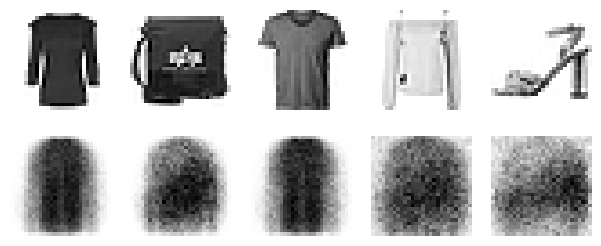

In [22]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [23]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4336 - rounded_accuracy: 0.8122 - val_loss: 0.4273 - val_rounded_accuracy: 0.8172
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4157 - rounded_accuracy: 0.8262 - val_loss: 0.4111 - val_rounded_accuracy: 0.8308
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4012 - rounded_accuracy: 0.8376 - val_loss: 0.3981 - val_rounded_accuracy: 0.8406
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3901 - rounded_accuracy: 0.8458 - val_loss: 0.3887 - val_rounded_accuracy: 0.8474
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3823 - rounded_accuracy: 0.8513 - val_loss: 0.3822 - val_rounded_accuracy: 0.8524
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3767 - rounded_accuracy: 0.8556 - val_loss: 0.3775 - val_rounded_accuracy: 0.8561
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 66ms/step


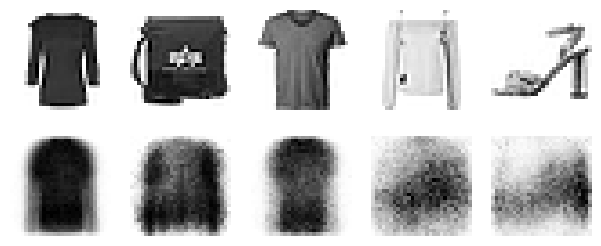

In [24]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Autoencoders con CNNs

Nota: Para el decoder se debe incluir la operación de deconvolución o convolución transpuesta

![cnn](https://i.stack.imgur.com/YyCu2.gif)

![tcnn](https://i.stack.imgur.com/f2RiP.gif)

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 14s 6ms/step - loss: 0.5841 - rounded_accuracy: 0.6975 - val_loss: 0.4848 - val_rounded_accuracy: 0.7813
Epoch 2/5
1719/1719 [==============================] - 9s 6ms/step - loss: 0.3994 - rounded_accuracy: 0.8562 - val_loss: 0.3710 - val_rounded_accuracy: 0.8739
Epoch 3/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3597 - rounded_accuracy: 0.8782 - val_loss: 0.3531 - val_rounded_accuracy: 0.8817
Epoch 4/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3452 - rounded_accuracy: 0.8861 - val_loss: 0.3413 - val_rounded_accuracy: 0.8900
Epoch 5/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3352 - rounded_accuracy: 0.8941 - val_loss: 0.3329 - val_rounded_accuracy: 0.8974


In [28]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)        

1/1 [==============================] - 0s 338ms/step


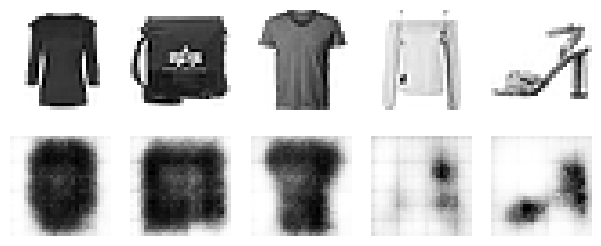

In [29]:
show_reconstructions(conv_ae)
plt.show()

# Stacked denoising Autoencoder

Se busca regularizar mediante ruido, generalmente Gaussiano, o aplicando dropout

Utilizando ruido Gaussiano:

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2), #std
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 4ms/step - loss: 0.6588 - rounded_accuracy: 0.6015 - val_loss: 0.5960 - val_rounded_accuracy: 0.6978
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5408 - rounded_accuracy: 0.7275 - val_loss: 0.5087 - val_rounded_accuracy: 0.7425
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4982 - rounded_accuracy: 0.7509 - val_loss: 0.4930 - val_rounded_accuracy: 0.7575
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4854 - rounded_accuracy: 0.7654 - val_loss: 0.4805 - val_rounded_accuracy: 0.7720
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4711 - rounded_accuracy: 0.7808 - val_loss: 0.4641 - val_rounded_accuracy: 0.7869
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4529 - rounded_accuracy: 0.7960 - val_loss: 0.4447 - val_rounded_accuracy: 0.8014
Epoch 7/10
1719/1719 [================

1/1 [==============================] - 0s 129ms/step


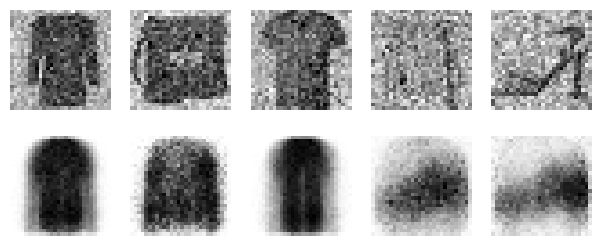

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Con dropout:

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6717 - rounded_accuracy: 0.5800 - val_loss: 0.6055 - val_rounded_accuracy: 0.6843
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5476 - rounded_accuracy: 0.7193 - val_loss: 0.5109 - val_rounded_accuracy: 0.7371
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5023 - rounded_accuracy: 0.7431 - val_loss: 0.4962 - val_rounded_accuracy: 0.7499
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4906 - rounded_accuracy: 0.7552 - val_loss: 0.4851 - val_rounded_accuracy: 0.7643
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4777 - rounded_accuracy: 0.7705 - val_loss: 0.4696 - val_rounded_accuracy: 0.7802
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4601 - rounded_accuracy: 0.7868 - val_loss: 0.4505 - val_rounded_accuracy: 0.7950
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 65ms/step
Saving figure dropout_denoising_plot


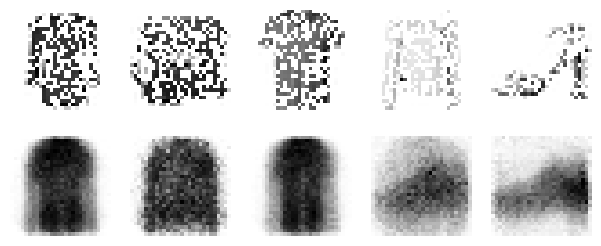

In [36]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

# Sparse Autoencoder

- Busca disminuir la cantidad de neuranas activas en el encoder.
- Se usa una sigmoid en el encoder con regularización l1
- Otras alternativas incluyen el mse con l1 y l2, o incluso la Divergencia KL sobre las activaciones de las neuronas para regularizar (sparse).

In [37]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6751 - rounded_accuracy: 0.5765 - val_loss: 0.6490 - val_rounded_accuracy: 0.6497
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6126 - rounded_accuracy: 0.6874 - val_loss: 0.5763 - val_rounded_accuracy: 0.7115
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5467 - rounded_accuracy: 0.7226 - val_loss: 0.5262 - val_rounded_accuracy: 0.7263
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5131 - rounded_accuracy: 0.7312 - val_loss: 0.5071 - val_rounded_accuracy: 0.7306
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5011 - rounded_accuracy: 0.7332 - val_loss: 0.5004 - val_rounded_accuracy: 0.7301
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4965 - rounded_accuracy: 0.7326 - val_loss: 0.4975 - val_rounded_accuracy: 0.7296
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 76ms/step


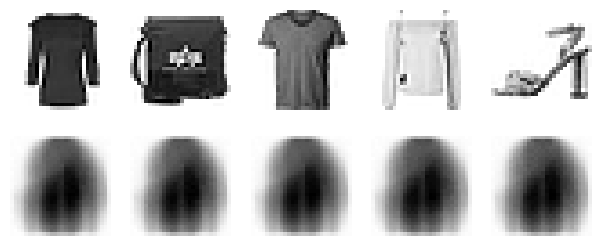

In [38]:
show_reconstructions(simple_ae)
plt.show()

Cálculo de histogramas para revisar la frecuencia de activación:

In [39]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [40]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

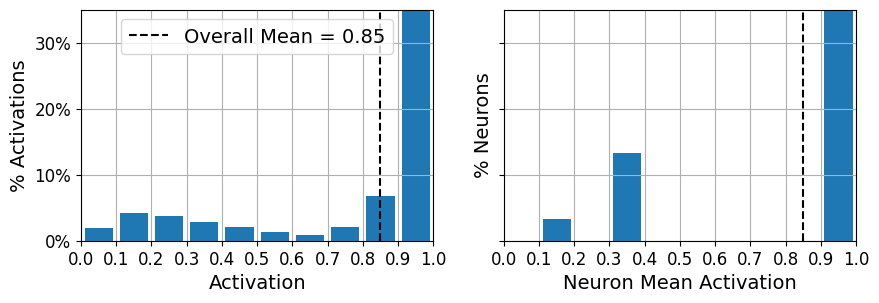

In [41]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Con regularización l1:

In [42]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7975 - rounded_accuracy: 0.6114 - val_loss: 0.7420 - val_rounded_accuracy: 0.6862
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6853 - rounded_accuracy: 0.7123 - val_loss: 0.6396 - val_rounded_accuracy: 0.7234
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6102 - rounded_accuracy: 0.7302 - val_loss: 0.5896 - val_rounded_accuracy: 0.7296
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5727 - rounded_accuracy: 0.7311 - val_loss: 0.5616 - val_rounded_accuracy: 0.7280
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5506 - rounded_accuracy: 0.7309 - val_loss: 0.5444 - val_rounded_accuracy: 0.7279
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5366 - rounded_accuracy: 0.7304 - val_loss: 0.5331 - val_rounded_accuracy: 0.7275
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 71ms/step


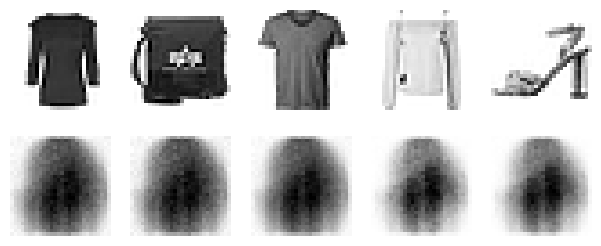

In [43]:
show_reconstructions(sparse_l1_ae)

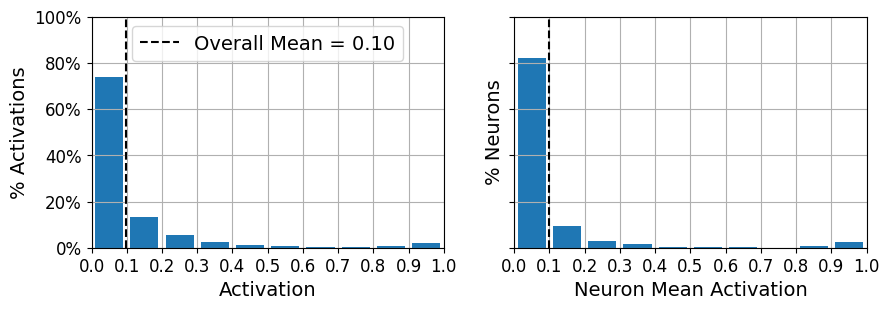

In [44]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Aplicar la divergencia KL para asegurar un 10% de sparsity

Saving figure sparsity_loss_plot


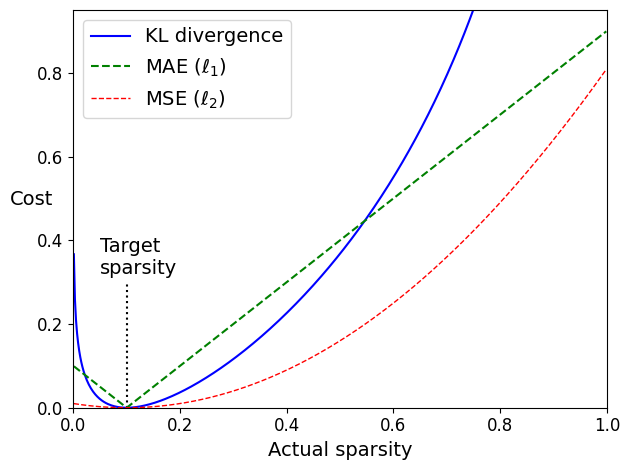

In [45]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [46]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [47]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.7833 - rounded_accuracy: 0.6050 - val_loss: 0.6947 - val_rounded_accuracy: 0.6829
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6338 - rounded_accuracy: 0.7087 - val_loss: 0.5896 - val_rounded_accuracy: 0.7167
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5613 - rounded_accuracy: 0.7218 - val_loss: 0.5417 - val_rounded_accuracy: 0.7223
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5272 - rounded_accuracy: 0.7253 - val_loss: 0.5187 - val_rounded_accuracy: 0.7237
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5101 - rounded_accuracy: 0.7255 - val_loss: 0.5063 - val_rounded_accuracy: 0.7217
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5002 - rounded_accuracy: 0.7237 - val_loss: 0.4985 - val_rounded_accuracy: 0.7207
Epoch 7/10
1719/1719 [=================

1/1 [==============================] - 0s 90ms/step


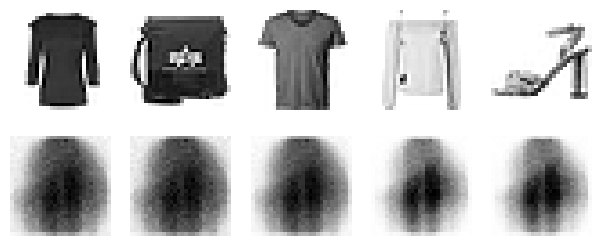

In [48]:
show_reconstructions(sparse_kl_ae)

Saving figure sparse_autoencoder_plot


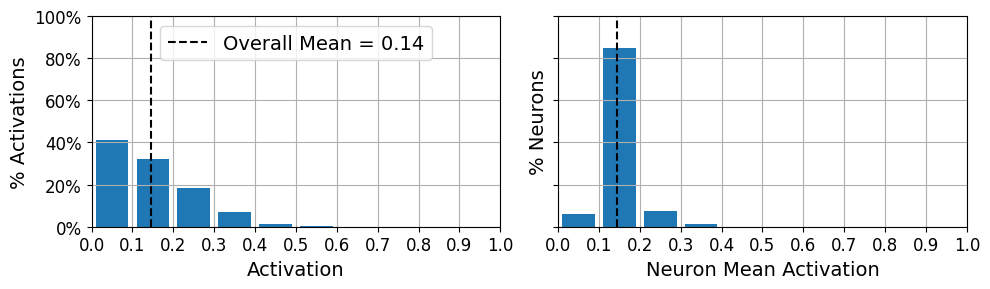

In [49]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

# [Variational Autoencoder](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)



Traditional Autoencoders deconstruct input data into a latent representation, and then using this latent space they reconstruct the original data. During this process, the Neural Network discovers which features are the most important for the reconstruction process and which ones can be ignored.
<div>
<img src=https://media.springernature.com/lw685/springer-static/image/chp%3A10.1007%2F978-3-030-31756-0_4/MediaObjects/480626_1_En_4_Fig2_HTML.png>
</div>

However, there are issues associated with the Latent Space: This latent space is not necesarily continuous between classes, and as such if a new data point lands in between classes, the network won't be able to handle it and will produce a garbage output.
<div>
<img src=https://miro.medium.com/v2/resize:fit:1400/1*xCjoga9IPyNUSiz9E7ao7A.png>
</div>

To solve this issue, Variational Autoencoders (VAE) try to force the latent space to a known probability distribution

The encoder normally produces a latent space, but in a VAE, the encoder produces a latent distribution $q(z|x)$, we then sample this distribution to create our latent space and reconstruct as normal.

<div>
<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*ejNnusxYrn1NRDZf4Kg2lw@2x.png" style="background-color:white;"/>
</div>




This latent distribution is compared to our posterior distribution $p(z|x)$ and through the cost function the goal is to minimize the difference between them.
$$q(z|x) ≈ p(z|x)$$

There is one big issue with this approach, thanks to Bayes' Theorem we know
$$p(z|x) = \frac{p(x|z)p(z)}{p(x)}$$
Where $p(x|z)$ is our reconstruction likelihood

$p(z)$ is our prior known distribution

and $p(x)$ is the evidence

Calculating the evidence turns out to be imposible due to the intractable nature of the evidence.
$$p(x) = ∫p(x|z)p(z)dz$$

At some point we need to find a way to estimate this evidence. Let's take a step back however, and get as far as we can calculating $q(z|x) ≈ p(z|x)$. We know the Kullback-Leibler divergence acts as a pseudo-distance for probability density functions, so we can use it to estimate the difference between $q$ and $p$

$$D_{kl}(q||p) = 𝔼_q\{log\begin{pmatrix}\frac{q(z|x)}{p(z|x)}\end{pmatrix}\}$$
Since we know the evidence can't be calculated, let's manipulate the formula to try and isolate it. We know the $log$ of a quotient is equals to the difference between $logs$:

$$D_{kl}(q||p) = 𝔼_q\{log(q(z|x) - log(p(z|x)\}$$


The Expectancy of a sum/subtraction is the sum/substraction of the expetancies:
$$D_{kl}(q||p) = 𝔼_q\{log(q(z|x)\} - 𝔼_q\{log(p(z|x)\}$$
Applying Bayes' Theorem to p(z|x):
$$D_{kl}(q||p) = 𝔼_q\{log(q(z|x)\} - 𝔼_q\{log\begin{pmatrix}\frac{p(x|z)p(z)}{p(x)}\end{pmatrix}\}$$
Once again separating the $log$ into a difference and splitting the Expectancy we get:
$$D_{kl}(q||p) = 𝔼_q\{log(q(z|x)\} - (𝔼_q\{log(p(x|z)p(z))\} - 𝔼_q\{log(p(x))\})$$
$$= 𝔼_q\{log(q(z|x)\} - 𝔼_q\{log(p(x|z)p(z))\} + 𝔼_q\{log(p(x))\}$$

Now we expand $𝔼_q\{log(p(x))\}$ and get:

$$D_{kl}(q||p) = 𝔼_q\{log(q(z|x)\} - 𝔼_q\{log(p(x|z)p(z))\} + \int q(z|x)log(p(x))dz$$
Since our evidence isn't in terms of $z$, we can pull it out of the integral:
$$D_{kl}(q||p) = 𝔼_q\{log(q(z|x)\} - 𝔼_q\{log(p(x|z)p(z))\} + log(p(x))\int q(z|x)dz$$
and by definition, the integral of any density function is 1, so:
$$D_{kl}(q||p) = 𝔼_q\{log(q(z|x)\} - 𝔼_q\{log(p(x|z)p(z))\} + log(p(x))\times 1$$
$$= 𝔼_q\{log(q(z|x)\} - 𝔼_q\{log(p(x|z)p(z))\} + log(p(x))$$

Now we can estimate our evidence $p(x)$ by isolating it:

$$log(p(x)) = D_{kl}(q||p) + 𝔼_q\{log(p(x|z)p(z))\} - 𝔼_q\{log(q(z|x)\}$$

We can't calculate $D_{kl}(q||p)$ as discussed earlier, but we also know, since it is a pseudo-distance, that it will always be greater or equal to $0$, so we can estimate our evidence as:

$$log(p(x)) \geq 𝔼_q\{log(p(x|z)p(z))\} - 𝔼_q\{log(q(z|x)\}$$

This is what's known as the **Evidence Lower Bound (ELBO)**, and it tells us that by maximizing $𝔼_q\{log(p(x|z)p(z))\} - 𝔼_q\{log(q(z|x)\}$ we can not only approximate $p(x)$, but also minimize $D_{kl}(q||p)$. Now let us manipulate it a little bit more to make it easier to use:

$$ELBO = 𝔼_q\{log(p(x|z)p(z))\} - 𝔼_q\{log(q(z|x)\}$$
The $log$ of a product is the sum of the $logs$:
$$ELBO = 𝔼_q\{log(p(x|z)) + log(p(z))\} - 𝔼_q\{log(q(z|x)\}$$
Once again splitting the Expectancy:
$$ELBO = 𝔼_q\{log(p(x|z))\} + 𝔼_q\{log(p(z))\} - 𝔼_q\{log(q(z|x)\}$$
Now we reorder the equation:
$$ELBO = 𝔼_q\{log(p(x|z))\} - 𝔼_q\{log(q(z|x)\} + 𝔼_q\{log(p(z))\}$$
Factor the negative sign from the last two terms:
$$ELBO = 𝔼_q\{log(p(x|z))\} - (𝔼_q\{log(q(z|x)\} - 𝔼_q\{log(p(z))\})$$
And finally we rejoin the Expectancy and the $logs$ for our last two terms:
$$ELBO = 𝔼_q\{log(p(x|z))\} - 𝔼_q\{log\begin{pmatrix}\frac{q(z|x)}{p(z)}\end{pmatrix}\}$$

In this form we can easily see how our first term represents the negative crossentropy between $q(z|x)$ and $p(x|z)$, while the second represent the Kullback-Leibler divergence for our encoder output $q(z|x)$ and our known prior distribution $p(z)$. So maximizing the **ELBO** comes down to minimizing the reconstruction error and the KL Divergence between the latent distribution and our prior.

![vae](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*eRcdr8gczweQHk--1pZF9A@2x.png)

In [50]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [51]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 5s 8ms/step - loss: 0.4121 - rounded_accuracy: 0.8369 - val_loss: 0.3695 - val_rounded_accuracy: 0.8701
Epoch 2/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3551 - rounded_accuracy: 0.8887 - val_loss: 0.3490 - val_rounded_accuracy: 0.8934
Epoch 3/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3443 - rounded_accuracy: 0.8968 - val_loss: 0.3487 - val_rounded_accuracy: 0.8975
Epoch 4/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3378 - rounded_accuracy: 0.9012 - val_loss: 0.3389 - val_rounded_accuracy: 0.8976
Epoch 5/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3333 - rounded_accuracy: 0.9043 - val_loss: 0.3367 - val_rounded_accuracy: 0.9044
Epoch 6/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3303 - rounded_accuracy: 0.9064 - val_loss: 0.3345 - val_rounded_accuracy: 0.9053
Epoch 7/25
430/430 [==============================] 

1/1 [==============================] - 0s 136ms/step


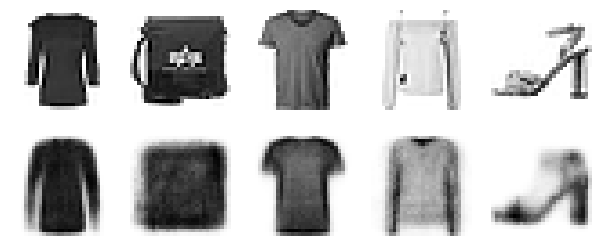

In [52]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

In [53]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Se generan puntos en el espacio latente y se reconstruyen las imágenes:

Saving figure vae_generated_images_plot


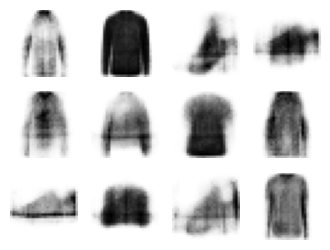

In [54]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Interpolación semántica: se pasan las imágenes por el encoder, se interpolan los dos puntos en el espacio latente, y la interpolación en el espacio latente se pasa por el decoder.

Saving figure semantic_interpolation_plot


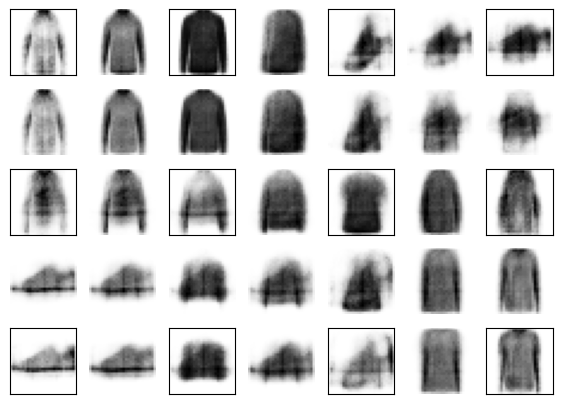

In [55]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

# [Generative Adversarial Networks (GANs)](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29)

Variational autoencoders fueron y son muy populares, pero las GANs surgen como una alternativa para generar imágenes más realistas.

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [57]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False # despues de compilar discriminator se entrena si se llama su .fit o su train_on_batch, no se  entrena en metodos de gan
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [58]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [59]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)
        plt.show()

Epoch 1/1


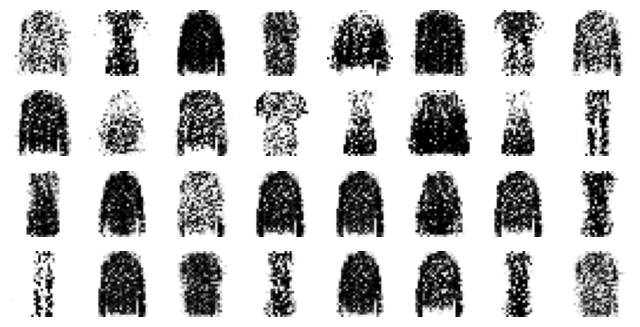

In [60]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Saving figure gan_generated_images_plot


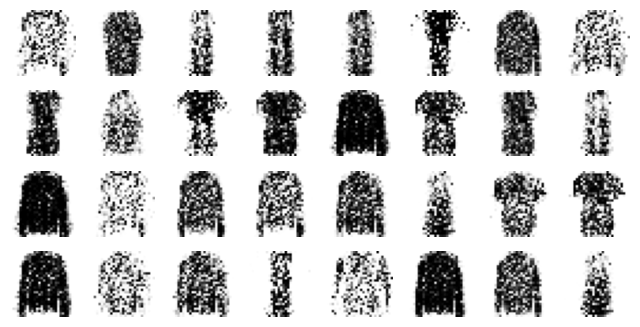

In [61]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

Epoch 1/50


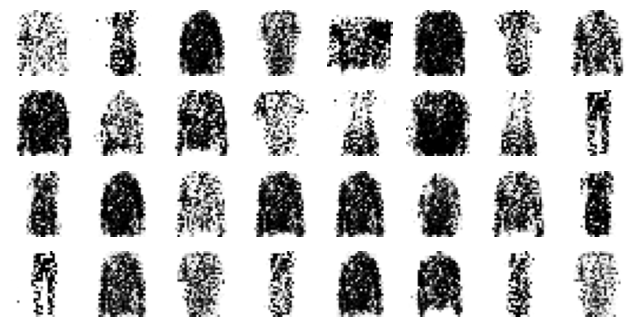

Epoch 2/50


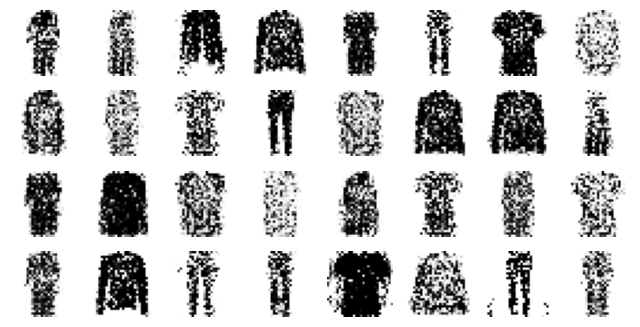

Epoch 3/50


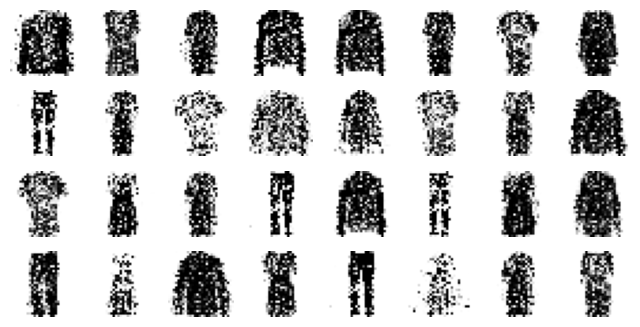

Epoch 4/50


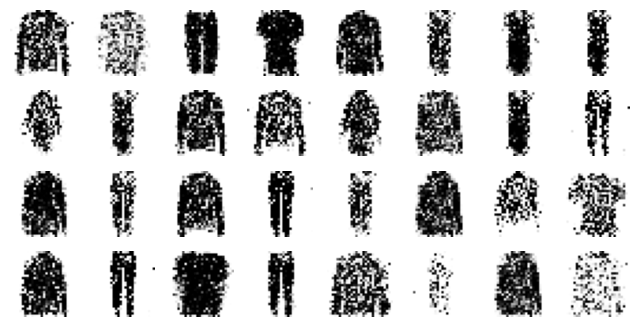

Epoch 5/50


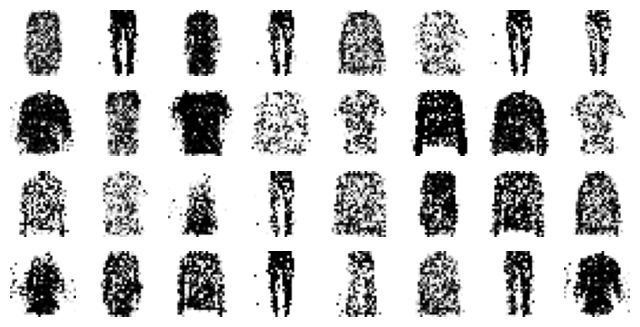

Epoch 6/50


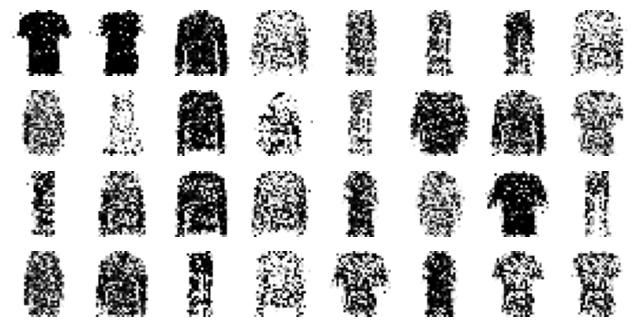

Epoch 7/50


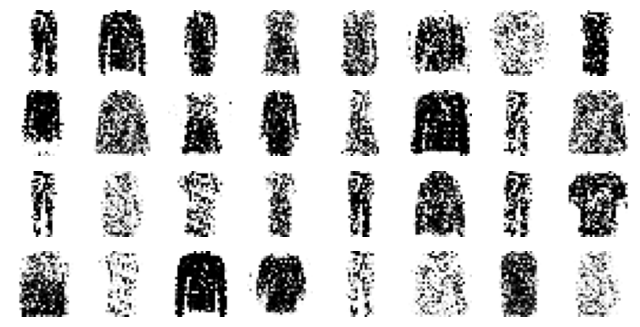

Epoch 8/50


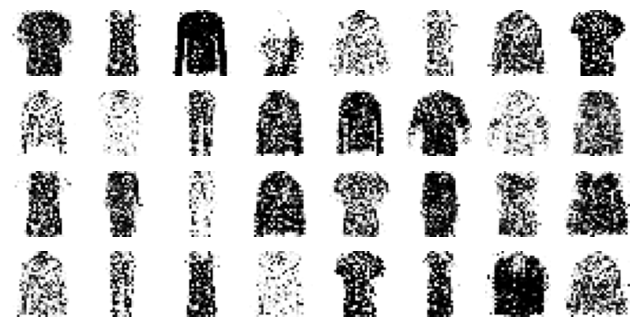

Epoch 9/50


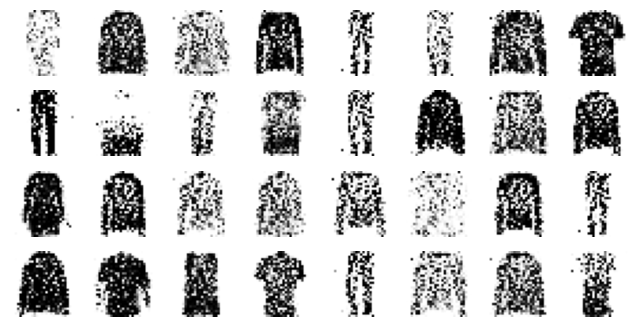

Epoch 10/50


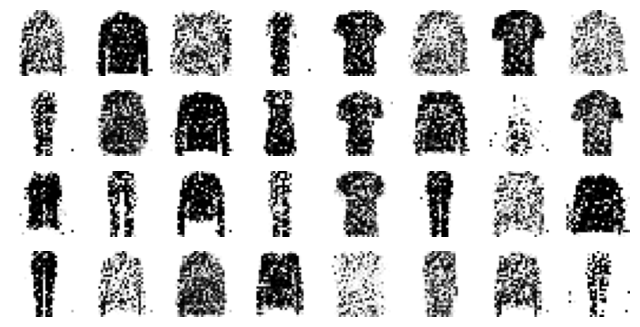

Epoch 11/50


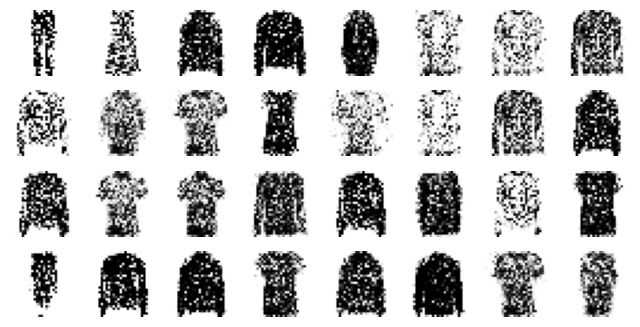

Epoch 12/50


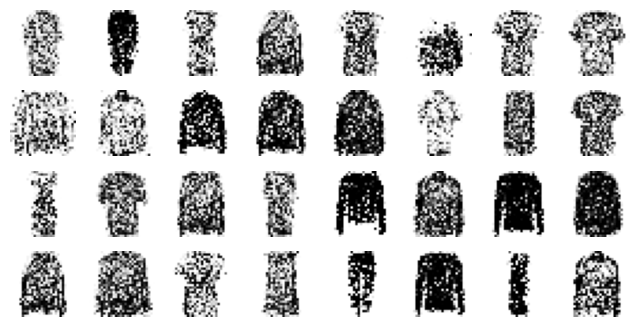

Epoch 13/50


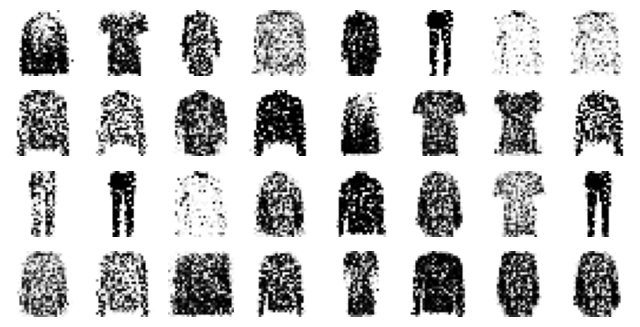

Epoch 14/50


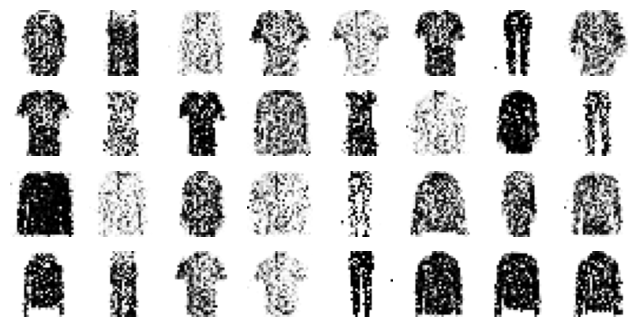

Epoch 15/50


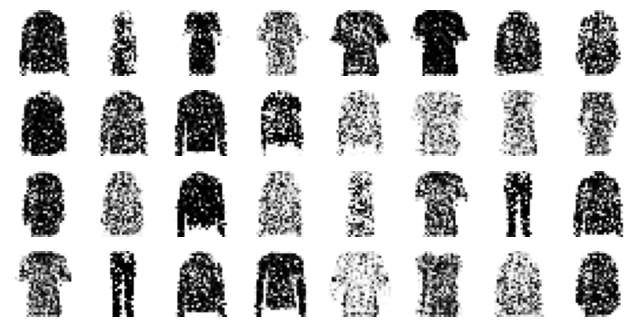

Epoch 16/50


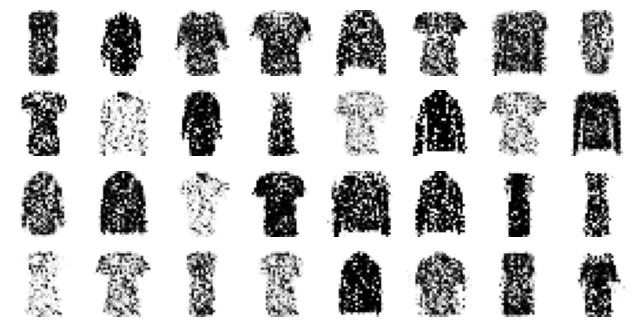

Epoch 17/50


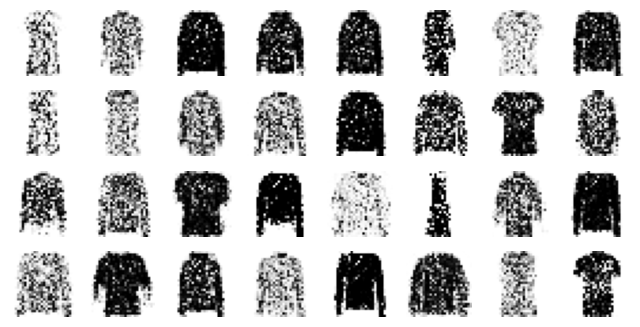

Epoch 18/50


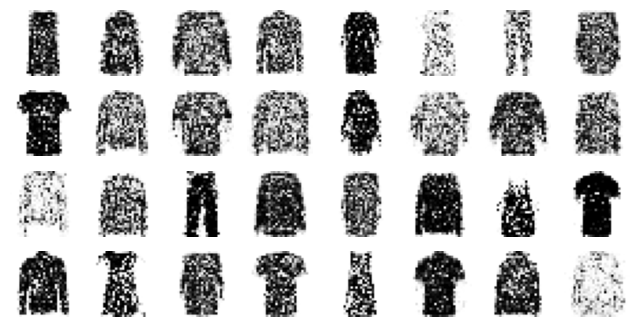

Epoch 19/50


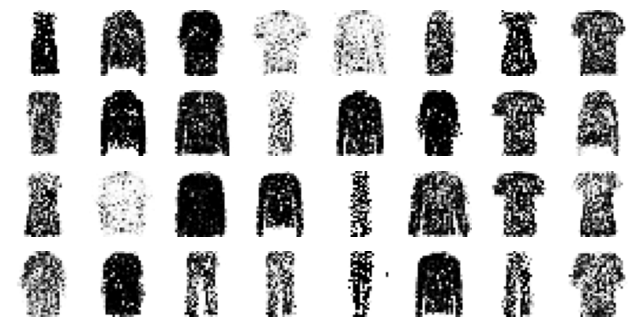

Epoch 20/50


KeyboardInterrupt: 

In [62]:
train_gan(gan, dataset, batch_size, codings_size)


# Deep Convolutional GAN

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)